# Ejercicio Text Mining 1 - Deteccion de sentimiento en tweets


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

Para el ejercicio se va a  entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos **:
        -	Se va a hacer un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds ...

    -	Se van a generar funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos **

    Se van a usar estrategias de vectorización como TF-IDF y Word Embeddings. Será necesario incorporar características adicionales como el sentimiento o características léxicas.

-	**Entrenamiento y validación del sistema **
  -	En el proceso de entrenamiento del modelo se van a testear al menos 3 modelos de clasificación. El procedimiento será primero una estimación del rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


## 0. Imports y def. de funciones


In [ ]:
import sys
!{sys.executable} -m pip install contractions
!pip install spacy==3.2.1
!python -m spacy download en_core_web_sm
import nltk
nltk.download('stopwords')
nltk.download('punkt')
!pip install emoji_extractor

2024-05-15 12:02:27.008865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 12:02:27.009004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 12:02:27.013774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 12:02:28.895526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.2.0/en_core_web_sm-3.2.0-py3-none-any.whl#egg=en_core_web_sm==3.2.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behavio

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import contractions
import scipy as sp

from tqdm.autonotebook import tqdm
tqdm.pandas()
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import TweetTokenizer

from emoji_extractor.extract import Extractor
from collections import Counter
from matplotlib import font_manager
from textblob import TextBlob
import gensim.downloader as api

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

# Balanceo de clases
from imblearn.over_sampling import SMOTE

<ipython-input-2-c81d0d1fda81>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
######################################################### DEFINICION DE FUNCIONES###############################

# FUNCION load_prepare_data, CARGA Y PROCESA DATOS APRA EL EJERCICIO
def load_prepare_data(path):

  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# FUNCION eliminar_espacios, ELIMINA ESPACIOS DEL TEXTO

def eliminar_espacios(text):
    return  " ".join(text.split())

# FUNCION texto_to_lower, CONVIERTE EL TEXTO A MINUSCULA

def texto_to_lower(text):
  return text.lower()

# FUNCION replace_contraction, REEMPLAZA CONTRACTIONS DEL TEXTO TRATADO PREVIAMENTE.

def replace_contraction(text):
    return contractions.fix(text, slang=True)

# FUNCION normalizar_tokens: NORMALIZAR URLs, MENCIONES Y NUMEROS.

def normalizar_tokens(documento):
    # Dividir el documento en palabras
    palabras =  tweet_tokenizer.tokenize(documento) # tokenize(documento)

    # Reemplazar URLs, menciones de Twitter y números por los tokens correspondientes
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "URL"
        elif palabras[i].startswith("@"): #startswith "@"
            palabras[i] = "MENTION"
        elif palabras[i].isdigit(): # .isdigit()
            palabras[i] = "NUM"

    # Unir las palabras de nuevo en un documento modificado
    documento_modificado = ' '.join(palabras)

    return documento_modificado

# FUNCION lematizar_eliminacion_tokens: LEMATIZAR TEXTO, ELIMINAR DE PUNTUACIÓN Y STOPWORDS.

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lematizar_eliminacion_tokens(texto):
    # Procesar el texto con el objeto nlp
    doc = nlp(texto)

    # Lematizar el texto
    lemas = [token.lemma_ for token in doc]

    # Eliminar símbolos de puntuación ( Aquellos tokens que no sean alfanuméricos) y stopwords (definidos en ingles)
    tokens_filtrados = [token for token in lemas if token.isalpha() and token.lower() not in en_stopwords]

    # Unir los tokens filtrados en un nuevo texto
    texto_procesado = ' '.join(tokens_filtrados)

    return texto_procesado

# FUNCION token_appearance, contabiliza el numero de apariciones de cada token en función de su naturaleza, por ejemplo menciones, URLs o números.

def token_appearance(document, token = "MENTION"):
  return len([x for x in document.split() if x == token])

# FUNCION  extract_emojis PARA EXTRAER EMOJIS DEL TEXTO EN FORMATO LISTA

def extract_emojis(text):
  extract = Extractor()
  emojis = extract.count_emoji(text, check_first=False)
  emojis_list = [key for key, _ in emojis.most_common()]
  return emojis_list

# FUNCION get_emoji_sentiment, extrae el sentimiento de cada emoticono

def get_emoji_sentiment(lista, option = "positive"):
  output = 0
  for emoji in lista:
    try:
      if option == "positive":
        output = output + emoji_sent_dict[emoji]["Positive"]
      elif option =="negative":
        output = output + emoji_sent_dict[emoji]["Negative"]
      elif option =="neutral":
        output = output + emoji_sent_dict[emoji]["Neutral"]
    except Exception as e:
      continue

  if len(lista)>=1:
    longitud = len(lista)
  else:
    longitud =1
  return output/ longitud

# FUNCION model_evaluation, encargada de evaluar el modelo

def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore')
          # Generamos un StratifiedKFold
          KF = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)

          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names


# FUNCION tokenize, Tokeniza los tweets con el tokenizador "TweetTokenizer" de NLTK
def tokenize(texto):
  tweet_tokenizer = TweetTokenizer()
  tokens_list = tweet_tokenizer.tokenize(texto)
  return tokens_list

# FUNCION normalizar_tokens, normaliza URLs, menciones y numeros de los tweets


def normalizar_tokens(documento):

    tweet_tokenizer = TweetTokenizer()
    # Dividir el documento en palabras
    palabras =  tweet_tokenizer.tokenize(documento)

    # Reemplazar URLs, menciones de Twitter y números por los tokens correspondientes
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "URL"
        elif palabras[i].startswith("@"):
            palabras[i] = "MENTION"
        elif palabras[i].isdigit():
            palabras[i] = "NUM"

    # Unir las palabras de nuevo en un documento modificado
    documento_modificado = ' '.join(palabras)

    return documento_modificado


#FUNCION get_average_vector que calcula un vector promedio para una oración dada

glove_emb = api.load('glove-twitter-25') # Descargamos y cargamos el embedding de "glove-twitter-25"

def get_average_vector(sentence):
  #retokenizamos con nuestra función
  tokens = tokenize(sentence)
  lista = list()
  for i in tokens:
    try:
      lista.append(glove_emb.get_vector(i) )
    except:
      continue

  try:
    resultado = np.mean(lista, axis=0)
  except:
    resultado = np.zeros(25)
  return resultado

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


[==================================================] 100.0% 104.8/104.8MB downloaded


## 1. Obtención del corpus
Para la obtención de los datos esta disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para poder realizarse.

In [ ]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
# Path de datos alternativos en caso de que el anterior no funcione (al estar alojado en github puede haber limitaciones
# en la descarga.
# path_data = "https://zenodo.org/records/10938455/files/cyberbullying_tweets.csv?download=1"
dataset = load_prepare_data(path_data)

In [ ]:
dataset.head()

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


## 2. Análisis exploratorio (EDA)

Se va a realizar una exploración y un análisis de los datos, entendiendo la naturaleza del corpus del que disponemos y los posibles inconvenientes que deberemos solucionar.

Vamos a transformar la columna "tweet_text" de nuestro dataset a una lista como paso previo al analisis exploratorio

In [ ]:
# Transformar la columna "tweet_text" a una lista
texto_tweets = dataset["tweet_text"].to_list() #
print(type(texto_tweets))

<class 'list'>


* **Numero de documentos y numero de columnas del dataframe del dataset:**

In [ ]:
# número de documentos y de columnas

print("Nuestro dataset tiene {} documentos".format(len(texto_tweets)))
print("El dataset tiene {} columnas".format(dataset.shape[1]))

Nuestro dataset tiene 47692 documentos
El dataset tiene 2 columnas


* **Número de documentos duplicados:**

In [ ]:
# Mostrar la cantidad de documentos duplicados

print("Existen {} documentos duplicados en el corpus, con los campos tweet_text coincidentes.".format(len(dataset[dataset.duplicated(subset=["tweet_text"], keep=False)])))
print("Existen {} documentos duplicados en el corpus, con los campos tweet_text y cyberbullying coincidentes.".format(len(dataset[dataset.duplicated(subset=["tweet_text", "cyberbullying"], keep=False)])))

Existen 3350 documentos duplicados en el corpus, con los campos tweet_text coincidentes.
Existen 332 documentos duplicados en el corpus, con los campos tweet_text y cyberbullying coincidentes.


En consideración con los 47692 documentos totales que contiene nuestro corpus, encontramos 3350 documentos con tweet_text duplicado, y 332 documentos duplicados en las columnas tweet_text y cyberbullying. Es decir, hay documentos que estando duplicados, tienen asignado tanto al valor 0 de cyberbulling, como al valor 1.

Se puede deducir que ha habido algún tipo de error a la hora de transformarlos o cargarlos. Habra que eliminar uno de los 2 documentos, en el caso de estar duplicados tanto el campo tweet_text como cyberbulling, y eliminar ambos documentos si tienen asignado tanto el valor 0 como 1 en el campo cyberbulling.

* **Valores Nulls dentro del corpus:**

No nos encontramos documentos con valores Null dentro del Corpus.

In [ ]:
#Valores Nulls
print("Hay {} valores vacíos en las noticias y {} valores vacíos en las etiquetas en los datos".format(np.sum(dataset.isnull())[0],
                                                                                                      np.sum(dataset.isnull())[1]))

Hay 0 valores vacíos en las noticias y 0 valores vacíos en las etiquetas en los datos


* **Número de documentos por cada categoría:**

Obtenemos que nuestro corpus esta muy desbalanceado, encontramos que aproximadamente un 80% de los datos, pertenecen a la categoría de cyberbulling y un 20% no. Este desbalanceo tendrá consecuencías a la hora de crear nuestro modelo, tendremos que valorar la ejecución de técnicas de rebalanceo como el uso de imblearn haciendo resample del conjunto de datos o el ajuste del hyperparámetro 'class_weight' en los modelos.

In [ ]:
dataset.groupby(["cyberbullying"]).count()

,tweet_text
cyberbullying,
0,7945
1,39747


Ejemplos de tweets con cyberbullying:

In [ ]:
dataset[dataset.cyberbullying==1].sample(5).tweet_text.to_list()

["Because femininity is so horrible! @JonnyG313 I'm not sexist but if a dude cries because of a girl in a wedding dress then he has a vagina",
 '@devesine @CrashOverrideNW eh, this is turning into more of a legal concern.',
 "And secondly Lockdown is to keep down the creeps like u instigating violence in name of Jihad and Islam...probably u might hav heard that word Islamic terrorism from Trump too...that's what ur real face...",
 'YES HAI DANA UR ONE OF MY FIRST MOOTS ILY',
 '@FunkyreFresh thanks. :)  it happened a few years ago. I wish she could have seen this. it would have tickled her to no end.']

Vemos que hay menciones, insultos y algún hashtag que deberemos analizar como #MKR

Ejemplos de tweets sin cyberbullying:

In [ ]:
dataset[dataset.cyberbullying==0].sample(5).tweet_text.to_list()

["RT @landofcoIfer: it's been one year since this joke and i'm still pissed about how cruel this was https://t.co/R6lrwGXnIP",
 '@ncoghlan_dev @srhbutts I hate cats.',
 '@BourgeoisBit Thank you Roooobbb!!!',
 '@CenationProud hey whats up',
 '“@PublimetroMX: Ninel Conde, víctima del bullying en Twitter, cambia su cuenta http://t.co/pFE73I7”/// aaaaaaaaaajajajajajajajahahahajahaja']

Al igual que en lso tweets positivos, vemos bastantes menciones, pero no se ven insultos.

* **Histograma por categoría de cyberbulling**

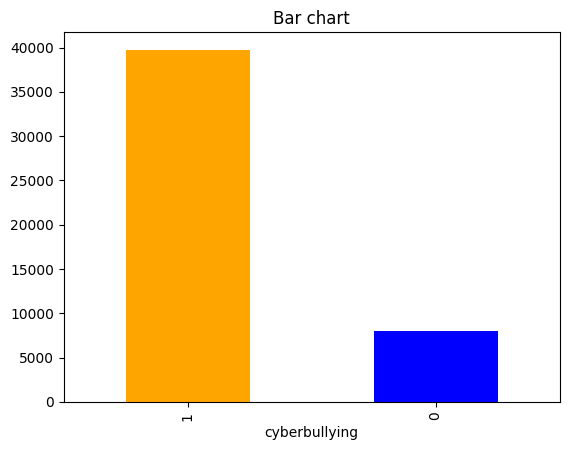

In [ ]:
ax, fig = plt.subplots()
etiquetas = dataset.cyberbullying.value_counts()
etiquetas.plot(kind= 'bar', color= ["orange", "blue"])
plt.title('Bar chart')
plt.show()


* **Distribución de la longitud de los tweet en carácteres:**

In [ ]:
dataset["char_len"] = dataset["tweet_text"].apply(lambda x:len(x)) # lambda y len

Se añade la variable char_len con la longitud del texto al dataset

In [ ]:
dataset.head(3)

,tweet_text,cyberbullying,char_len
0,"In other words #katandandre, your food was cra...",0,61
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60


Segun las especificaciones de Tweeter (Ahora X), los tweets deben tener un máximo de 280 caracteres, cualquier tweet con mas de 280 carácteres podremos argumentar que ha habido un error en el proceso de transcripción, y podremos considerarlo erroneo, o podremos tratarlo como un caso de tweet más y valorar en caso de encontrarnos en un caso real con tweets de > de 280 caracteres como categorizarlos.

In [ ]:
print("Existen {} documentos con más de 280 carácteres".format(sum(dataset['char_len'] > 280)))

Existen 704 documentos con más de 280 carácteres


Examinando los datos de la distribución de la longitud de los tweets encontramos que la longitud mínima es de 1 solo caracter y la longitud máxima es de 5018 caracteres. Tweets que podríamos considerar erroneos, pero que vamos a tratar igualmente para ser mas exhaustivos.

In [ ]:
dataset['char_len'].describe()

count    47692.000000
mean       136.253229
std         85.226899
min          1.000000
25%         78.000000
50%        124.000000
75%        180.000000
max       5018.000000
Name: char_len, dtype: float64

Ahora se van a visualizar la distribución de la longitud de los tweets y el valor de cyberbulling asignado, pero para ser más especificos, voy a mostrar por un lado la distribución de los tweets con 280 caracteres o menos, y por otro lado los que sean mayores de 280 carácteres, así como los valores asociados de cyberbulling.

In [ ]:
dataset_280_min = dataset[ dataset.char_len <= 280]
dataset_280_max = dataset[ dataset.char_len > 280]


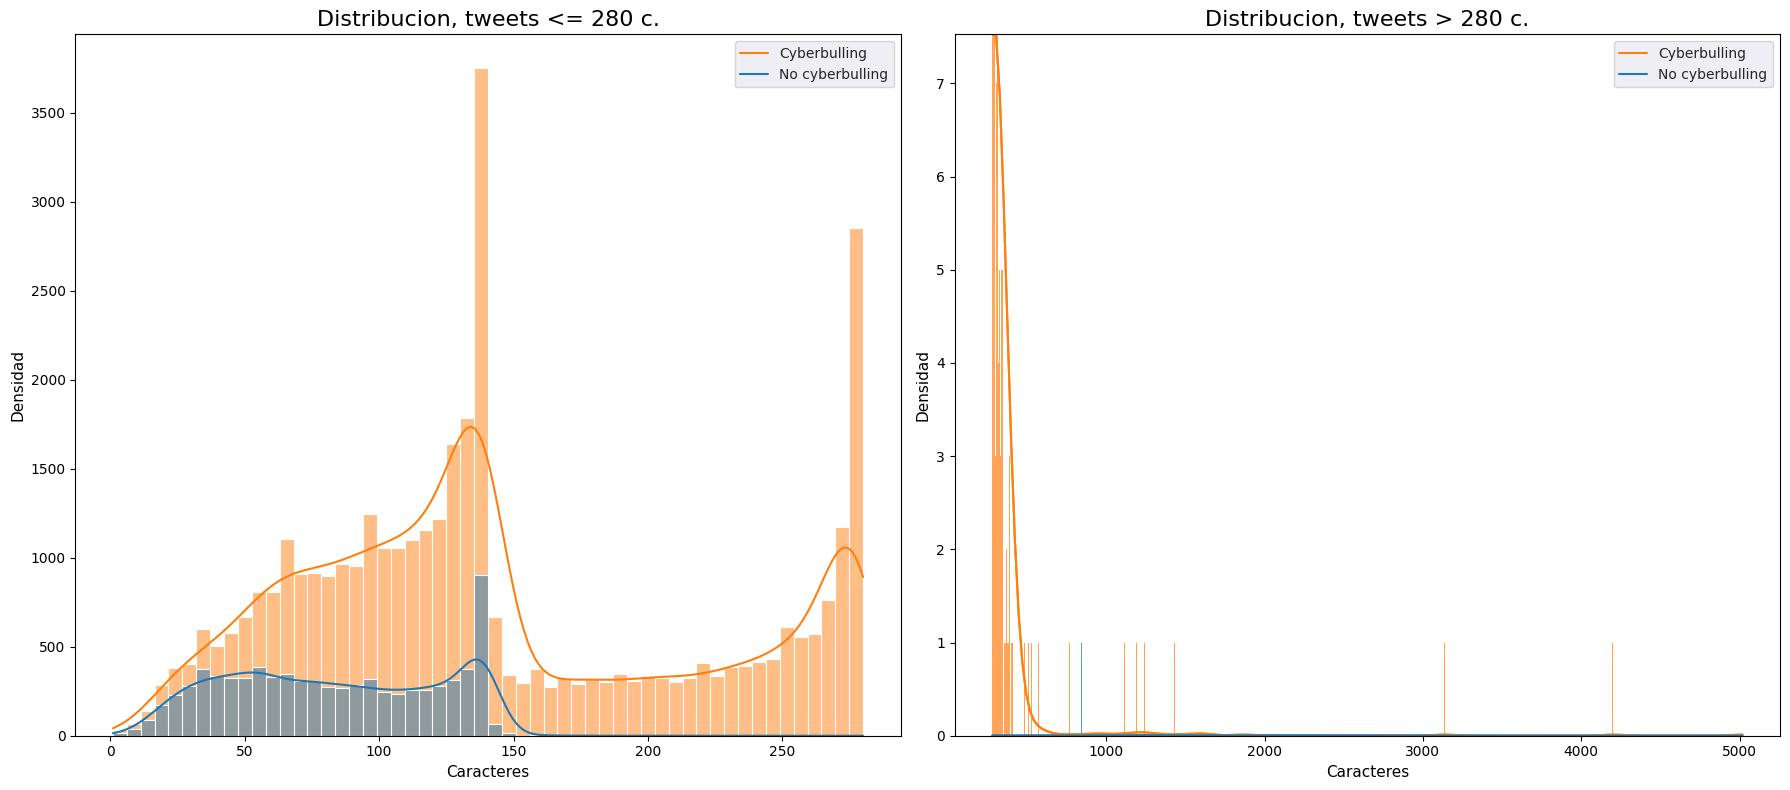

In [ ]:
# Crear la figura y los subgráficos
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Establecer el estilo de seaborn
sns.set_style("darkgrid")

# Primer gráfico
sns.histplot(data=dataset_280_min, x="char_len", hue="cyberbullying", kde=True, legend=True, ax=axes[0])


# Definimos el título de los ejes:
axes[0].legend(["Cyberbulling", "No cyberbulling"])
axes[0].set_title('Distribucion, tweets <= 280 c.', fontsize=16)
axes[0].set_xlabel('Caracteres', fontsize=11)
axes[0].set_ylabel('Densidad', fontsize=11)

# Segundo gráfico
sns.histplot(data=dataset_280_max, x="char_len", hue="cyberbullying", kde=True, legend=True,  ax=axes[1])

max_density = max(sns.histplot(data=dataset_280_max, x="char_len", hue="cyberbullying", kde=True).get_lines()[0].get_data()[1])

# Definimos el título de los ejes:
axes[1].legend(["Cyberbulling", "No cyberbulling"])
axes[1].set_title('Distribucion, tweets > 280 c.', fontsize=16)
axes[1].set_xlabel('Caracteres', fontsize=11)
axes[1].set_ylabel('Densidad', fontsize=11)
axes[1].set_ylim(0, max_density)  # Establecer el límite máximo del eje Y al valor máximo de densidad

# Finalmente mostramos el gráfico:
plt.tight_layout()
plt.show()

En el gráfico de la distribución de tweets con <= de 280 caracteres, los que suponemos como tweets extraidos correctamente, se puede apreciar que hasta los 150 carácteres, nos encontramos con mayor número de tweets de cyberbulling en cuanto aumenta el número de carácteres.

Aumenta desde 0 a 140, obteniendo un primer pico sobre los 140 caracteres, y luego baja y se mantiene su distribución desde los 150 hasta alrededor de los 250 donde comienza a subir de nuevo, formando un nuevo pico en los 280.

En cuanto a los tweets no etiquetados con cyberbulling su distribución aumenta desde los 0 a los 40 carácteres, manteniendose hasta los 140 de forma constante donde llega a su valor máximo.
A partir de los 150 podríamos considerar que no existen tweets etiquetados ocmo cyberbulling.

En cuanto al grafico con tweets > de 280 carácteres, vemos que se acumulan cercanos al inicio, al rededor de 300 caracteres de longitud, y luego va habiendo algun caso aislado, todo ellos casos de cyberbulling a excepción de un tweet alrededor de los 1000 carácteres. Podríamos deducir que cualquier documento de + de 280 carácteres es un tweet de cyberbulling, asumiendo tambien que deben ser codificaciones erroneas, pero se va a decidir mantener peusto que es un escenario real al que nos vamos a encontrar con datos reales futuros.

* **Visualización del contenido de los tweets con Wordcloud:**

Se va a usar de la visualización mediante wordcloud para enfatizar los términos más frecuentes dentro de los tweets, con wordcloud se da mayor tamaño o menos en funcion de la concurrencia de cada término. Esto es interesante pero tendremos que volverlo a ver puesto que los stopwords, menciones numeros van a distorsionar la composición de esta composición. Nos interesa ver la frecuencia de términos cuando hayamos normalizado el texto, eliminado términos no relevantes.

Como paso previo, hay que generar una variable tipo string con todos los textos concatenados por cada una de las categorías de cyberbulling:

In [ ]:
txt_cyberbullying_0 = ",".join(dataset[dataset.cyberbullying==0].tweet_text.to_list()) # Nos quedamos con dataset.cyberbullying==0
txt_cyberbullying_1 = ",".join(dataset[dataset.cyberbullying==1].tweet_text.to_list()) # Nos quedamos con dataset.cyberbullying==0

Generamos objeto WordCloud con los parametros elegidos

In [ ]:
#Defino los stopwords en ingles
en_stopwords = stopwords.words("english") # 'english'

#Creo un objeto WordCloud con los parámetros.
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0,
                      contour_color='steelblue', stopwords=en_stopwords,
                      normalize_plurals = True)

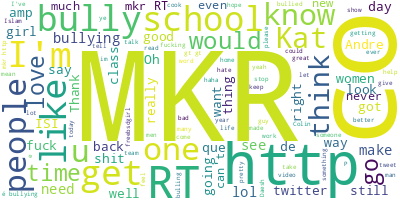

In [ ]:
# Genera el wordcloud para cyberbullying = 0
wordcloud.generate(txt_cyberbullying_0)
# Visualizalo en una imagen
wordcloud.to_image()

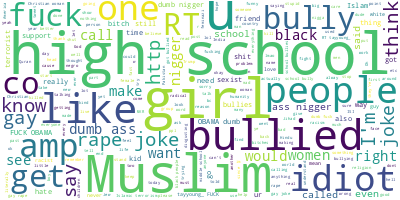

In [ ]:
# Genera el wordcloud para cyberbullying = 1
wordcloud.generate(txt_cyberbullying_1)
# Visualizalo en una imagen
wordcloud.to_image()

Se pueden obtener las siguientes conclusiones del wordCloud:
Para los casos de No Cyberbullying, aparecen enlaces de páginas web (http y co), etiquetas de Tweeter como RT o MKR ( Que en un principio no está muy claro que es), y términos como school o incluso love.

Para los casos de cyberbullying, palabras como high school, muslim, bullied girl o algunos insultos, son las más predominantes, ademas de que a diferencia de los casos de no cyberbulling, no es mayoritario la aparicion de enlaces webs (http o co).

## Análisis de sentimiento / emoticonos

En esta parte, se va a hacer un analisis de la presencia y uso de emojis en los documentos y se va a analizar el sentimiento asociado. Se vinculará un nivel de sentimiento según si tiene emoticonos a cada uno de los documentos, siendo esta una característica más que enriquecerá nuestro futuro modelo. A posteriori, también se calculará el sentimiento asociado al propio texto, pero esto se hará en la fase de caracteristicas adicionales.

El primer paso es observar cuantos de los documentos de nuestro corpus tienen emojis, pero para ello, previamente necesitamos extraer como caracteristica de cada documento si contiene o no emojis, para ello haremos uso de la funcion extract_emojis.

Extraemos los emojis a una columna especifica en el dataframe:

In [ ]:
dataset["emojis"] = dataset["tweet_text"].apply(lambda x: extract_emojis(x))

In [ ]:
tweets_con_emoji = dataset[dataset['emojis'].apply(lambda x: len(x) >= 1)]
tweets_sin_emoji = dataset[dataset['emojis'].apply(lambda x: len(x) ==0)]

# Imprimir el resultado
print("Número de filas con al menos un icono:", len(tweets_con_emoji))
print("Número de filas sin iconos:", len(tweets_sin_emoji))

Número de filas con al menos un icono: 440
Número de filas sin iconos: 47252


In [ ]:
# Contar el número de tweets etiquetados como cyberbullying=1
num_tweets_cyberbullying_1 = len(dataset[dataset.cyberbullying==1])
print("Número de tweets etiquetados como cyberbullying = 1:", num_tweets_cyberbullying_1)

# Filtrar los tweets etiquetados como cyberbullying=1 y que contengan emojis
tweets_cyberbullying_1_con_emoji = dataset[(dataset.cyberbullying == 1) & (dataset.emojis.apply(len) > 0)]

# Contar el número de tweets filtrados
num_tweets_cyberbullying_1_con_emoji = len(tweets_cyberbullying_1_con_emoji)
print("Número de tweets de cyberbullying=1 con emoji:", num_tweets_cyberbullying_1_con_emoji)

# Calcular el porcentaje de tweets con cyberbullying=1 que tienen emojis
porcentaje_tweets_cyberbullying_1_con_emoji = (num_tweets_cyberbullying_1_con_emoji / num_tweets_cyberbullying_1)
print("Porcentaje de tweets de cyberbullying = 1 que tienen emoji:", porcentaje_tweets_cyberbullying_1_con_emoji)

Número de tweets etiquetados como cyberbullying = 1: 39747
Número de tweets de cyberbullying=1 con emoji: 216
Porcentaje de tweets de cyberbullying = 1 que tienen emoji: 0.005434372405464564


In [ ]:
# Contar el número de tweets etiquetados como cyberbullying=0
num_tweets_cyberbullying_0 = len(dataset[dataset.cyberbullying==0])
print("Número de tweets etiquetados como cyberbullying = 0:", num_tweets_cyberbullying_0)

# Filtrar los tweets etiquetados como cyberbullying=1 y que contengan emojis
tweets_cyberbullying_0_con_emoji = dataset[(dataset.cyberbullying == 0) & (dataset.emojis.apply(len) > 0)]

# Contar el número de tweets filtrados
num_tweets_cyberbullying_0_con_emoji = len(tweets_cyberbullying_0_con_emoji)
print("Número de tweets de cyberbullying=0 con emoji:", num_tweets_cyberbullying_0_con_emoji)

# Calcular el porcentaje de tweets con cyberbullying=1 que tienen emojis
porcentaje_tweets_cyberbullying_0_con_emoji = (num_tweets_cyberbullying_0_con_emoji / num_tweets_cyberbullying_0)
print("Porcentaje de tweets de cyberbullying = 0 que tienen emoji:", porcentaje_tweets_cyberbullying_0_con_emoji)

Número de tweets etiquetados como cyberbullying = 0: 7945
Número de tweets de cyberbullying=0 con emoji: 224
Porcentaje de tweets de cyberbullying = 0 que tienen emoji: 0.028193832599118944


Tenemos 387 documentos con emojis y 44121 sin emojis, es decir, ni siquiera un 1% de los documentos tiene emoji, por lo que si queremos evaluar la característica del sentimiento, ademas del uso de emojis tendremos que hacerlo analizando otras características de los tweets. Para ello haremos uso de TextBlob para aportar la polaridad y subjetividad del texto pero esto lo haremos en el proceso de añadir características adicionales al dataset.

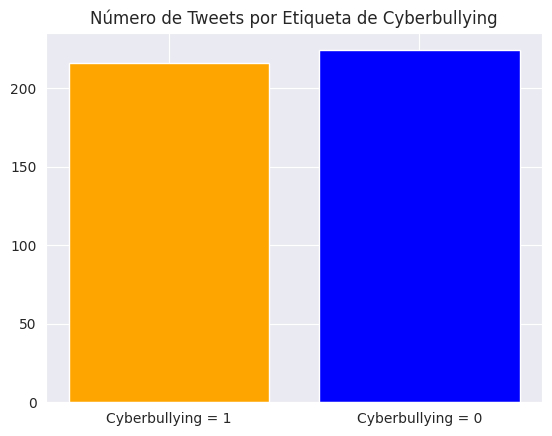

In [ ]:
# Datos
etiquetas = ['Cyberbullying = 1', 'Cyberbullying = 0']
num_tweets = [num_tweets_cyberbullying_1_con_emoji, num_tweets_cyberbullying_0_con_emoji]

# Crear gráfico de barras
plt.bar(etiquetas, num_tweets, color=['orange', 'blue'])
plt.title('Número de Tweets por Etiqueta de Cyberbullying')
plt.show()

Se va a visualizar el top-10 de resultados en un barplot:

<ipython-input-29-eb9a48ea7637>:32: UserWarning: Glyph 128548 (\N{FACE WITH LOOK OF TRIUMPH}) missing from current font.
  plt.tight_layout()
<ipython-input-29-eb9a48ea7637>:32: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from current font.
  plt.tight_layout()
<ipython-input-29-eb9a48ea7637>:32: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128548 (\N{FACE WITH LOOK OF TRIUMPH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


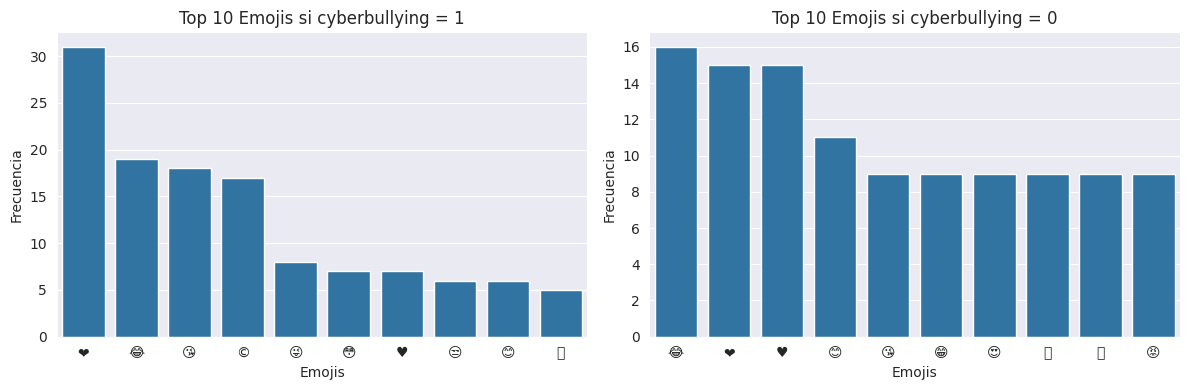

In [ ]:
# Filtrar las filas con icono y cyberbullying == 1
filas_con_icono_y_cyberbullying_1 = tweets_con_emoji[tweets_con_emoji.cyberbullying==1].emojis.to_list()

# Filtrar las filas con icono y cyberbullying == 0
filas_con_icono_y_cyberbullying_0 = tweets_con_emoji[tweets_con_emoji.cyberbullying==0].emojis.to_list()

filas_con_icono_y_cyberbullying_1 = [item for sublist in filas_con_icono_y_cyberbullying_1 for item in sublist]
filas_con_icono_y_cyberbullying_0 = [item for sublist in filas_con_icono_y_cyberbullying_0 for item in sublist]

freq_icono_y_cyberbullying_1 = Counter(filas_con_icono_y_cyberbullying_1)
freq_icono_y_cyberbullying_0 = Counter(filas_con_icono_y_cyberbullying_0)

emojis1, frecuencias_elementos1 = zip(*sorted(freq_icono_y_cyberbullying_1.items(), key=lambda x: x[1], reverse=True)[:10])
emojis0, frecuencias_elementos0 = zip(*sorted(freq_icono_y_cyberbullying_0.items(), key=lambda x: x[1], reverse=True)[:10])


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Barplot 1
sns.barplot(x=emojis1, y=frecuencias_elementos1, ax=axes[0])
axes[0].set_xlabel('Emojis')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Top 10 Emojis si cyberbullying = 1')

# Barplot 2
sns.barplot(x=emojis0, y=frecuencias_elementos0, ax=axes[1])
axes[1].set_xlabel('Emojis')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Top 10 Emojis si cyberbullying = 0')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la imagen
plt.show()

La informacion obtenida de los emoticonos asociados a los tweets es un poco contradictoria, aparecen iconos aparentemente positivos tanto en los tweets con cyberbullying como en los sin  cyberbullying como pueden ser los corazones. Parece que los emojis no son demasiado determinantes a la hora de determinar la naturaleza del tweet, este aspecto concuerda con que según obtuvimos con anterioridad, tan solo al rededor del 1% de los tweets tenian emojis asociados. Sin embargo, el añadir características asociadas a si un tweet tiene o no emoticonos y su sentimiento asociado enriquecerá el modelo como un input más a valorar.

## 3. Preprocesado y Normalización

En este punto, preparamos los datos de texto para el posterior análisis. Buscando sobre todo hacer hincapie en los siguientes aspectos:

- Gestionar los tweets duplicados.
- Tokenizar, dividir el texto en unidades más pequeñas denominadas tokens.
- Eliminar ruido, eliminar caracteres especiales, signos de puntuacion, numeros y otros caracteres que no aportan información relevante.
- Eliminar Stopwords, estas no aportan significado per se al texto, por lo que no nos interesan que entren al modelo.
- Normalización de texto, se convierten todas las letras a minúsculas para garantizar la consistencia en el texto. Tambien vamos a realizar otras formas de normalización, como la lematización o la eliminación de contracciones, para reducir la variabilidad y simplificar el análisis.

#### Gestión de Duplicados

En la parte del preprocesado, se van a eliminar tweets duplicados.
Como ya vimos que teniamos 2 tipos de duplicados:

- Documentos con los campos tweet_text y cyberbulling duplicado, en este caso , me quedaré con 1 de los dos.
- Documentos duplicados y con diferente valor del campo cyberbulling, eliminaré ambos tweets al entender que están mal codificados y es un error de conversión.

In [ ]:
# Comprobar documentos duplicados en las columnas tweet_text y cyberbullying

# Mostrar la cantidad de documentos duplicados
print("Existen {} documentos duplicados en el corpus, con los campos tweet_text y cyberbullying coincidentes.".format(len(dataset[dataset.duplicated(subset=["tweet_text", "cyberbullying"], keep=False)])))

# Eliminar duplicados en las columnas tweet_text y cyberbullying
dataset_dup_cleaned_1 = dataset.drop_duplicates(subset=["tweet_text", "cyberbullying"], keep="first")

# Mostrar la cantidad de documentos duplicados
print("Existen {} documentos duplicados con las columnas tweet_text y cyberbullying coincidentes, despues de hacer la limpieza.".format(len(dataset_dup_cleaned_1[dataset_dup_cleaned_1.duplicated(subset=["tweet_text", "cyberbullying"], keep=False)])))

Existen 332 documentos duplicados en el corpus, con los campos tweet_text y cyberbullying coincidentes.
Existen 0 documentos duplicados con las columnas tweet_text y cyberbullying coincidentes, despues de hacer la limpieza.


In [ ]:
# Comprobar documentos duplicados, con la columna tweet_text coincidente y cyberbullying distintos

# Mostrar la cantidad de documentos duplicados
print("Existen {} documentos duplicados en el corpus, con los campos tweet_text coincidentes y cyberbullying distinto.".format(len(dataset_dup_cleaned_1[dataset_dup_cleaned_1.duplicated(subset=["tweet_text"], keep=False)])))

# Eliminar duplicados en las columnas tweet_text y cyberbullying
dataset_dup_cleaned_2 = dataset_dup_cleaned_1.drop_duplicates(subset=["tweet_text"], keep=False)

# Mostrar la cantidad de documentos duplicados
print("Existen {} documentos duplicados con las columnas tweet_text coincidentes y distinto valor de cyberbulling, despues de hacer la limpieza.".format(len(dataset_dup_cleaned_2[dataset_dup_cleaned_2.duplicated(subset=["tweet_text"],keep=False)])))

dataset = dataset_dup_cleaned_2.reset_index(drop=True)


Existen 3018 documentos duplicados en el corpus, con los campos tweet_text coincidentes y cyberbullying distinto.
Existen 0 documentos duplicados con las columnas tweet_text coincidentes y distinto valor de cyberbulling, despues de hacer la limpieza.


In [ ]:
# Número de documentos

print("Después del proceso de limpiado del corpus, tenemos {} documentos,".format(len(dataset)))
print("de los cuales , existen {} documentos duplicados.".format(len(dataset[dataset.duplicated(subset=["tweet_text"],keep=False)])))


Después del proceso de limpiado del corpus, tenemos 44508 documentos,
de los cuales , existen 0 documentos duplicados.


<!-- En cuanto a la normalización de documentos, se van a realizar los siguientes procesos:

- Eliminar espacios extra entre términos.
- Transformar a minúsculas.
- Reemplazar contracciones del inglés.
- Normalizar URLs, menciones de twitter y números por tokens comunes.
- Lematizar tokens, eliminar stopwords y eliminar sígnos de puntuación. -->


#### Eliminar espacios extra entre términos y transformación de documentos a minúsculas:

Los espacios no aportan ningún valor lexico en el texto. Transformando a minúsculas, evitamos duplicados de palabras mayusculas/minusculas, además se reduce el numero de palabras a considerar y lo que buscamos es hacer hincapie en el aporte contextual de las palabras.

Usaremos la función eliminar_espacios para eliminar los espacios extra del texto y texto_to_lower para convertir todos los caracteres a minúsculas.

In [ ]:
# Espacios y minuscula
dataset["normalized"] = dataset["tweet_text"].progress_apply(lambda x: eliminar_espacios(x))
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: texto_to_lower(x))

  0%|          | 0/44508 [00:00<?, ?it/s]

  0%|          | 0/44508 [00:00<?, ?it/s]

In [ ]:
dataset["tweet_text"].sample(5)

23171    @WalkerWave20 @Awe_Some_Alex @BleacherReport S...
4474     What's the difference between American and Aus...
35198    She must have been that girl in high school th...
19568    Yes that’s right arabs arming other Muslim ara...
24514    @JakSoulbright @Stan_Philo  Sorry to hear that...
Name: tweet_text, dtype: object

In [ ]:
dataset["normalized"].sample(5)

18256    no, peta are idiots. doesnt justify her jumpin...
35579    i get a girl pregnant in high school so i told...
30014    teenager shoots up a school: society: omg how ...
25334    @tmclaughbos @_roguest4r but rogue isn't reall...
42779    you deluded?rt @kheyteekat: lady gaga said tha...
Name: normalized, dtype: object

Se comprueba que el proceso de quitar espacios y minusculas se hace correctamente.

#### **Reemplazar contracciones**

Se convierte el texto en una forma más normalizada y consistente. Esto ayuda a reducir la variabilidad en los datos lo que facilita el análisis y la comparación entre diferentes documentos.

Se normalizan las contracciones y slang del inglés haciendo uso de la libreria "contractions" https://github.com/kootenpv/contractions



In [ ]:
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: replace_contraction(x))

  0%|          | 0/44508 [00:00<?, ?it/s]

In [ ]:
dataset["tweet_text"].sample(5)

14867    @sabaajmal380 @ministryofstalk Islam worships ...
7658     @smitty_one_each @KatiePavlich @rsmccain These...
22764    I am now watching wadhwa be "very disappointed...
38552    The way black people act at restaurants is dis...
13665    #MKR that wiped that horrible smile off Kat's ...
Name: tweet_text, dtype: object

In [ ]:
dataset["normalized"].sample(5)

12771    you should ask any gay men you know to post on...
11316    what not to do: make rape/ gay/ feminist jokes...
3864     rt @tsnorway: the difference between crime and...
7600     psa: rape jokes are never funny and "gay" is n...
9534     i hate to call her a bitch, would one of my fe...
Name: normalized, dtype: object

#### Normalizar URLs, menciones de twitter y números por tokens comunes

Normalizar URLs, menciones de twitter y números por tokens comunes, nos ayuda a hacer un tratamiento de estas como si fuesen una sola entidad.

 Se van a realizar las siguientes sustituciones en los tokens:
- https: por 'URL'
- menciones (tokens que comiencen por @), por MENTION
- números por NUM

In [ ]:
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: normalizar_tokens(x))

  0%|          | 0/44508 [00:00<?, ?it/s]

In [ ]:
dataset["normalized"].head()

0    in other words #katandandre , your food was cr...
1    why is #aussietv so white ? #mkr #theblock #im...
2    MENTION a classy whore ? or more red velvet cu...
3    MENTION this is an isis account pretending to ...
4    MENTION MENTION yes , the test of god is that ...
Name: normalized, dtype: object

#### Lematizar tokens, eliminar stopwords y eliminar sígnos de puntuación

En la lematización de tokens, buscamos reducir las palabras a su forma base o lema, es decir al significado que aportan a la frase.

Los signos de puntuación y los stopwords, lexicamente no aportan nada, por lo que no aportan nada al contexto del texto y procedemos a eliminarlas.

Se usará la función lematizar_eliminacion_tokens, que lematiza y elimina stopwords y signos de puntuación.

In [ ]:
dataset["preprocessed_text"] = dataset["normalized"].progress_apply(lambda x: lematizar_eliminacion_tokens(x))

  0%|          | 0/44508 [00:00<?, ?it/s]

In [ ]:
dataset["tweet_text"].sample(5)

40021              @Gleaux_ NIGGER? I am mixed. dumb fuck.
11791    The menus look like they were made by a 5 year...
20152    Ok one more scan on the way , like how you hel...
29394    I just found out that the girl who bullied me ...
31343    I’m not even exaggerating. All the girls who b...
Name: tweet_text, dtype: object

In [ ]:
dataset["preprocessed_text"].sample(5)

34231    fuck hilarious terrify see girl bully high sch...
21838    agree idiot wmds storm state government buildi...
28344                                          game change
20919    much donna b use savior name vain right air fi...
32653                 want cyber bully school board member
Name: preprocessed_text, dtype: object

Se pueden ver tokens como MENTION en las muestras de "preprocessed_text"

## Características adicionales

Se va a añadir a los datos información adicional que nos puede servir a la hora de desarrollar nuestro modelo, como puede ser el número de URLs o las menciones de cada tweet haciendo uso de la funcion token_apparence que identifica el numero de tokens que aparecen en el tweet en funcion de su naturaleza.

Además de esto se va a añadir el sentimiento asociado a los emoticonos usados en cada documento, y el sentimiento asociado a los textos de los documentos con TextBob.

#### caract. menciones, URLs y num.

In [ ]:
dataset["num_mention"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="MENTION"))
dataset["num_URLS"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="URL"))
dataset["num_NUM"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="NUM"))

  0%|          | 0/44508 [00:00<?, ?it/s]

  0%|          | 0/44508 [00:00<?, ?it/s]

  0%|          | 0/44508 [00:00<?, ?it/s]

In [ ]:
dataset.head()

,tweet_text,cyberbullying,char_len,emojis,normalized,preprocessed_text,num_mention,num_URLS,num_NUM
0,"In other words #katandandre, your food was cra...",0,61,[],"in other words #katandandre , your food was cr...",word katandandre food crapilicious mkr,0,0,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115,[],why is #aussietv so white ? #mkr #theblock #im...,aussietv white mkr theblock imacelebrityau tod...,0,0,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60,[],MENTION a classy whore ? or more red velvet cu...,MENTION classy whore red velvet cupcake,1,0,0
3,@RudhoeEnglish This is an ISIS account pretend...,0,103,[],MENTION this is an isis account pretending to ...,MENTION isis account pretend kurdish account l...,1,0,0
4,"@Raja5aab @Quickieleaks Yes, the test of god i...",0,131,[],"MENTION MENTION yes , the test of god is that ...",MENTION MENTION yes test god good bad indiffer...,2,0,0


Procedemos a visualizar de nuevo los wordclouds para ver los cambios que se han producido una vez hemos normalizado el texto.

In [ ]:
txt_cyberbullying_preprocessed_0 = ",".join(dataset[dataset.cyberbullying==0].preprocessed_text.to_list()) # Nos quedamos con dataset.cyberbullying==0
txt_cyberbullying_preprocessed_1 = ",".join(dataset[dataset.cyberbullying==1].preprocessed_text.to_list()) # Nos quedamos con dataset.cyberbullying==0

Una vez ya tenemos nuestro dataset con el texto preprocesado, donde limpiamos los tweets duplicados, los espacios, hemos lematizado y eliminado los signos  de puntuación y stopwords,  normalizado las menciones, URLS y los tokens numéricos, procedemos a extraer el sentimiento de los emojis y del texto como característica adicional.

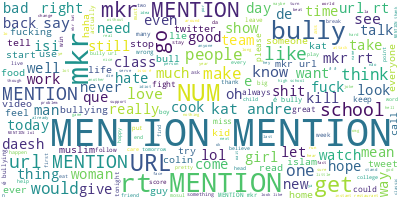

In [ ]:
# Genera el wordcloud para los datos preprocesados con cyberbullying = 0
wordcloud.generate(txt_cyberbullying_preprocessed_0)
# Visualizalo en una imagen
wordcloud.to_image()

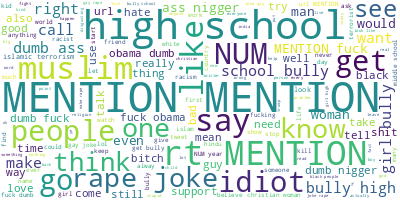

In [ ]:
# Genera el wordcloud para los datos preprocesados con cyberbullying = 1
wordcloud.generate(txt_cyberbullying_preprocessed_1)
# Visualizalo en una imagen
wordcloud.to_image()

Se puede comprobar que toman predominancia los tokens que hemos convertido de menciones (MENTION) tanto para tweets de cyberbullying como de no cyberbullying. Y aparece el token MRK posiblemente asociado a un programa televisivo de cocina donde se expusienron situaciones de misoginia.

#### Sentimientos emoji

Ahora vamos a extraer las características de los emojis, diferenciando entre positivo, neutral o negativo. Agregaremos lso campos sent_emoji_pos, neu y neg para determinar el nivel de sentimiento asociado a los emojis del tweet, ya sean negativos, neutros o positivos.

In [ ]:
dataset["sent_emoji_pos"] = dataset["emojis"].apply(lambda x: get_emoji_sentiment(x, "positive"))
dataset["sent_emoji_neu"] = dataset["emojis"].apply(lambda x: get_emoji_sentiment(x, "neutral"))
dataset["sent_emoji_neg"] = dataset["emojis"].apply(lambda x: get_emoji_sentiment(x, "negative"))

In [ ]:
dataset.head()

,tweet_text,cyberbullying,char_len,emojis,normalized,preprocessed_text,num_mention,num_URLS,num_NUM,sent_emoji_pos,sent_emoji_neu,sent_emoji_neg
0,"In other words #katandandre, your food was cra...",0,61,[],"in other words #katandandre , your food was cr...",word katandandre food crapilicious mkr,0,0,0,0.0,0.0,0.0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115,[],why is #aussietv so white ? #mkr #theblock #im...,aussietv white mkr theblock imacelebrityau tod...,0,0,0,0.0,0.0,0.0
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60,[],MENTION a classy whore ? or more red velvet cu...,MENTION classy whore red velvet cupcake,1,0,0,0.0,0.0,0.0
3,@RudhoeEnglish This is an ISIS account pretend...,0,103,[],MENTION this is an isis account pretending to ...,MENTION isis account pretend kurdish account l...,1,0,0,0.0,0.0,0.0
4,"@Raja5aab @Quickieleaks Yes, the test of god i...",0,131,[],"MENTION MENTION yes , the test of god is that ...",MENTION MENTION yes test god good bad indiffer...,2,0,0,0.0,0.0,0.0


#### Sentimientos: Polaridad y subjetividad en el texto

Calculo del sentimiento asociado a los textos haciendo uso de TextBlob, se añadiran los campos tweet_sentiment_polarity, que valora el nivel de polaridad del texto, y  tweet_sentiment_subjetivity que hace lo propio con la subjetividad.

In [ ]:
dataset["tweet_sentiment_polarity"] = dataset["preprocessed_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
dataset["tweet_sentiment_subjectivity"] = dataset["preprocessed_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
dataset.head()

,tweet_text,cyberbullying,char_len,emojis,normalized,preprocessed_text,num_mention,num_URLS,num_NUM,sent_emoji_pos,sent_emoji_neu,sent_emoji_neg,tweet_sentiment_polarity,tweet_sentiment_subjectivity
0,"In other words #katandandre, your food was cra...",0,61,[],"in other words #katandandre , your food was cr...",word katandandre food crapilicious mkr,0,0,0,0.0,0.0,0.0,0.000000,0.000000
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115,[],why is #aussietv so white ? #mkr #theblock #im...,aussietv white mkr theblock imacelebrityau tod...,0,0,0,0.0,0.0,0.0,0.000000,0.000000
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60,[],MENTION a classy whore ? or more red velvet cu...,MENTION classy whore red velvet cupcake,1,0,0,0.0,0.0,0.0,0.050000,0.450000
3,@RudhoeEnglish This is an ISIS account pretend...,0,103,[],MENTION this is an isis account pretending to ...,MENTION isis account pretend kurdish account l...,1,0,0,0.0,0.0,0.0,0.000000,0.000000
4,"@Raja5aab @Quickieleaks Yes, the test of god i...",0,131,[],"MENTION MENTION yes , the test of god is that ...",MENTION MENTION yes test god good bad indiffer...,2,0,0,0.0,0.0,0.0,-0.166667,0.755556


Como resultado del proceso de añadir características adicionales, se han agregado los siguientes campos a cada documento:
- num_mention: campo que contabiliza el numero de menciones en el tweet.
- num_URLS: Numero de URLs
- num_NUM: Cantidad de números en el texto
- sent_emoji_pos: Nivel de sentimiento positivo de los emoticonos.
- sent_emoji_neu: Nivel de sentimiento neutral de los emoticonos.
- sent_emoji_neg: Nivel de sentimiento negativo de los emoticonos.
- tweet_sentiment_polarity: Nivel de sentimiento de polaridad del texto.
- tweet_sentiment_subjectivity: Nivel de subjetividad del texto.

## 4. Vectorización

Para vectorizar vamos a usar la estrategia de tf-idf, ademas de la vectorización embedding.

### Vectorizacion TF-IDF

Con la vectorizacion tf-idf estamos valorando la frecuencia con la que aparece una palabra en el texto, y la importancia de esa palabra relativa a todo el conjunto de documentos.

Se asignarán puntuaciones altas en cuanto las palabras aparecen muchas veces pero son raras en la colección completa de documentos.

En el proceso de vectorizacion del texto, hay que tener cuidado para no llevar a cabo preprocesados ya efectuados, además de limitar el tamaño del vector con el atributo min_df:

lowercase = False, no minusculas.
ngram_range = (1,3), queremos gestionar unigramas, bigramas y trigramas.
min_df = 0.005 -> No considerar elementos que estén en menos de 0.005 documentos.


In [ ]:
vectorizador = TfidfVectorizer(lowercase = False, stop_words=None,
                               min_df=0.005, ngram_range = (1,3))

vector_data_tfidf = vectorizador.fit_transform(dataset["preprocessed_text"])

In [ ]:
vector_data_tfidf

<44508x416 sparse matrix of type '<class 'numpy.float64'>'
	with 378216 stored elements in Compressed Sparse Row format>

### Vectorizacion de embeddings

Con la vectorizacion de embeddings buscamos representar palabras o documentos como vectores numéricos en un espacio de características, lo que permite capturar relaciones semánticas entre palabras, en el proceso, vamos a usar el embedding de 'glove-twitter-25' entrenados con datos de twitter y con 25 dimensiones.

Aplicamos el proceso, y creamos la variable embeddings dentro del dataset.

In [ ]:
dataset["embeddings"] = dataset["preprocessed_text"].progress_apply(lambda x: get_average_vector(x))

  0%|          | 0/44508 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Es importante tener en cuenta que el formato de la columna embeddings es un vector, y que hay que unirlas a las columnas de características adicionales y tambien a los vectores tf-idf, que tienen un formato csr que tendremos que tratar para incorporar toda la información.

Convertimos los embeddings a serie de pandas para poder ir concatenando las demás características que tengo en mi dataset.

In [ ]:
extra_features = dataset[[
                          'num_mention','num_URLS','num_NUM',
                          'sent_emoji_pos','sent_emoji_neg','sent_emoji_neu',
                          'tweet_sentiment_polarity','tweet_sentiment_subjectivity'
                        ]]

vector_data_embeddings_feats = pd.concat([dataset.embeddings.apply(pd.Series),extra_features], axis=1)
vector_data_embeddings_feats = vector_data_embeddings_feats.fillna(0)

Utilizamos la librería scipy (función sparse.hstack) para unir las características TFIDF (vector_data_tfidf) con los vectores embeddings y las características adicionales (vector_data_embeddings_feats).

Esta unión nos generará una matriz X que utilizaremos para hacer el train-test split posteriormente.

In [ ]:
# Extraemos las etiquetas y las asignamos a la variable y
y = dataset["cyberbullying"].values.astype(np.float32)
# Unimos las características TFIDF con las características previamente seleccionadas

# Extraemos los valores (values) de las extra_features
X = sp.sparse.hstack((vector_data_tfidf,vector_data_embeddings_feats.values),format='csr')

In [ ]:
# Se extraen el nombre de las características que las necesitaremos para evaluar la importancia de cada una de ellas en el modelo
X_columns=list(vectorizador.get_feature_names_out())+extra_features.columns.tolist()

## 5. Entrenamiento y evaluación de modelos


Previamente a seleccionar el modelo, se va a dividir el dataset en Train/Test definiendo una semilla propia

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state=21,
                                                    stratify = y)
print(X_train.shape)
print(X_test.shape)

(33381, 449)
(11127, 449)


#### Balanceo de datos con libreria imblearn

Sabemos que tenemos unos datos con categorías desbalanceadas, para subsanarlo tenemos la opción de usar el hiperparámetro de class_weight a la hora de configurar el modelo, y podemos usar SMOTE - Synthetic Minority Over-sampling Technique de la libreria imblearn.

En un primer paso previo, vamos a entrenar los posibles modelos sin balancear los datos, para poder comparar con los modelos entrenados con los datos balanceados.

Definimos los modelos y generamos una lista con cada uno de ellos:
Vamos a probar LogisticRegression, GaussianNB, SVM, RandomForest y XGBOOST para comparar cual da mejor resultado, y usaremos el accuracy ya que es un buen indicador cuando tenemos muestras desbalanceadas.

In [ ]:
#RandomForestClassifier(class_weight={1: 1, 2: 1, 3: 2}
models = [
         ("Logistic",LogisticRegression(random_state=21)), # LogisticRegression(random_state=30)
         ("GaussianNB",GaussianNB()), # GaussianNB
         ("RandomForestClassifier",RandomForestClassifier(random_state=21)),
         ("XGBoost",XGBClassifier(random_state=21)),
         ("SVM",LinearSVC(random_state=21))
]

evaluation_score = "accuracy" # Como las muestras estan desbalanceadas, usamos accuracy
model_evaluation(models,evaluation_score, X_train.toarray(), y_train)

Metric: accuracy , KFold 
Logistic: 0.891944 (0.003544) 
Metric: accuracy , KFold 
GaussianNB: 0.612863 (0.008224) 
Metric: accuracy , KFold 
RandomForestClassifier: 0.899703 (0.002191) 
Metric: accuracy , KFold 
XGBoost: 0.901800 (0.000843) 
Metric: accuracy , KFold 
SVM: 0.892364 (0.002979) 


([array([0.89710948, 0.89484721, 0.88825644, 0.88825644, 0.89125225]),
  array([0.62138685, 0.61653685, 0.61923307, 0.6079988 , 0.59916117]),
  array([0.89995507, 0.89889155, 0.89934092, 0.90353505, 0.89679449]),
  array([0.90265089, 0.9027861 , 0.90083883, 0.90188736, 0.90083883]),
  array([0.89725925, 0.89364889, 0.88870581, 0.89005392, 0.89215099])],
 ['Logistic', 'GaussianNB', 'RandomForestClassifier', 'XGBoost', 'SVM'])

Sin los datos balanceados, obtenemos las siguientes puntuaciones:

- Logistic: 0.891944 (0.003544)
- GaussianNB: 0.612863 (0.008224)
- RandomForestClassifier: 0.899703 (0.002191)
- XGBoost: 0.901800 (0.000843)
- SVM: 0.892364 (0.002979)

Con los datos desbalanceados, nuestro mejor modelo es el modelo XGBoost, seguido muy de cerca por el RandomForest.

Como paso previo a probar los distintos hiperparámetros donde se planteará el uso de class_weight, voy a probar el modelo rebalanceado con SMOTE de la libreria imblearn.

Se aplica el rebalanceo solo a la X_train y y_train, no a las variables de test.

In [ ]:
# Creamos objetos
sm = SMOTE(random_state=42)
# Retransformamos
X_rebalanced, y_rebalanced = sm.fit_resample(X_train, y_train)

Resultado obtenido del rebalanceo:

In [ ]:
np.array(np.unique(y_rebalanced, return_counts=True)).T

array([[0.000e+00, 2.856e+04],
       [1.000e+00, 2.856e+04]])

De nuevo probamos los 5 modelos, ahora con los datos rebalanceados y comparamos resultados.

In [ ]:
model_evaluation(models,evaluation_score, X_rebalanced.toarray(), y_rebalanced)

Metric: accuracy , KFold 
Logistic: 0.860539 (0.001801) 
Metric: accuracy , KFold 
GaussianNB: 0.792822 (0.004701) 
Metric: accuracy , KFold 
RandomForestClassifier: 0.942087 (0.001057) 
Metric: accuracy , KFold 
XGBoost: 0.925263 (0.002231) 
Metric: accuracy , KFold 
SVM: 0.864513 (0.002314) 


([array([0.86318277, 0.85959384, 0.85845588, 0.85933123, 0.86213235]),
  array([0.79945728, 0.79052871, 0.79376751, 0.794993  , 0.78536415]),
  array([0.94310224, 0.94003852, 0.94240196, 0.9424895 , 0.94240196]),
  array([0.92655812, 0.9255077 , 0.92839636, 0.92183123, 0.92401961]),
  array([0.86904762, 0.86362045, 0.86257003, 0.86335784, 0.86397059])],
 ['Logistic', 'GaussianNB', 'RandomForestClassifier', 'XGBoost', 'SVM'])

Obtenemos los siguientes resultados, comparados con los anteriores:
- Logistic: 0.891944 (0.003544)   ->  0.860539 (0.001801)
- GaussianNB: 0.612863 (0.008224) ->  0.792822 (0.004701)
- RandomForestClassifier: 0.899703 (0.002191) -> 0.942087 (0.001057)
- XGBoost: 0.901800 (0.000843) -> 0.925263 (0.002231)
- SVM: 0.892364 (0.002979) -> 0.864513 (0.002314)


Vemos que el modelo de LogisticRegression incluso ha empeorado con los datos rebalanceados.
GaussianNB ha mejorado de un 0.61 a un 0.79, casi un 20% de mejora
RandomForestClassifier pasa de 0.90 a 0.942, una mejora del 4.2%.
XGBoost pasa de 0.90 a 0.925, una mejora de un 2.5%
SVM pasa de 0.892 a

Con los datos desbalanceados teniamos que XGBoost era nuestro mejor modelo a priori, despues de rebalancearlos nos quedamos con el modelo de RandomForest que ya no solo ha mejorado su puntuación, sino que se ha visto reducida la variacion de estos, de (0.002191) -> (0.001057)

Importante destacar, la gran mejora del modelo GaussianNB, y el empeoramiento tanto de LogisticRegression, como de SVM. Parece ser que no le sienta bien el rebalanceo de datos a ambos modelos, y actuan mejor usando el conjunto original.

#### Calculo de hiperparámetros.

Ahroa vamos a evaluar cuales son los mejores hiperparámetros de mi modelo RandomForest, debido al costo computacional y de tiempo se van a hacer una busqueda no muy extensa de hiperparámetros del modelo.

Dentro de los hiperparámetros vamos a probar a usar class_weight que sirve apra rebalancear los datos. En teoría no deberíamos probareste parámetro ya que los datos estan rebalanceados previamente con SMOTE, sin embargo, puede ser interesante ver que configuración nos devuelve el grid_search, voy a dejar la opcion de 'balanced' o None dentro de class_weight para ver que elije el modelo.

In [ ]:
model = RandomForestClassifier()
criterion = ['gini', 'entropy']
max_depth = [None,'2','4','10']
class_weight = ['balanced',  None, {0: 1, 1: 2}, {0: 1, 1: 3}]

In [ ]:
grid = dict(criterion=criterion,class_weight=class_weight, max_depth=max_depth )
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

Importante, destacar aqui que vamos a usar las variables X e Y de entrenamiento rebalanceadas, es decir,  X_rebalanced e y_rebalanced en vez de X_train e y_train.


In [ ]:
grid_result = grid_search.fit(X_rebalanced, y_rebalanced)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
#Mejor accuracy: 0.943715 usando los parámetros {'class_weight': {0: 1, 1: 3}, 'criterion': 'entropy', 'max_depth': None}

Como indicamos previamente, la busqueda de hiperparámetros, nos da como resultados que 'class_weight': {0: 1, 1: 3} es la mejor configuración, algo curisioso puesto que balanceamos previamente con SMOTE, pero hacemos caso a las indicaciones que nos ha dado el GridSearchCV. De igual manera, voy a sacar la matriz de confusion, y el classification report de un modelo usando class_weight y otro sin usar class_weigth para ver las diferencias entre ellos.

Una vez obtenido la configuración de hiperparámetros del mejor modelo, vamos a sacar la matriz de confusión y el classification report.

modelo con class_weight

In [ ]:
model = RandomForestClassifier(class_weight={0: 1, 1: 3}, criterion='entropy', max_depth=None, random_state=42)
model.fit(X_rebalanced,y_rebalanced)

y_pred = model.predict(X_test)

print("RandomForest con class_weight\n")
print(confusion_matrix(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred))

RandomForest con class_weight

[[1112  495]
 [ 833 8687]] 

              precision    recall  f1-score   support

         0.0       0.57      0.69      0.63      1607
         1.0       0.95      0.91      0.93      9520

    accuracy                           0.88     11127
   macro avg       0.76      0.80      0.78     11127
weighted avg       0.89      0.88      0.89     11127



modelo sin class_weight

In [ ]:
model = RandomForestClassifier(criterion='entropy', max_depth=None, random_state=42)
model.fit(X_rebalanced,y_rebalanced)

y_pred = model.predict(X_test)

print("RandomForest sin class_weight\n")
print(confusion_matrix(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred))

RandomForest sin class_weight

[[1153  454]
 [ 867 8653]] 

              precision    recall  f1-score   support

         0.0       0.57      0.72      0.64      1607
         1.0       0.95      0.91      0.93      9520

    accuracy                           0.88     11127
   macro avg       0.76      0.81      0.78     11127
weighted avg       0.90      0.88      0.89     11127



Vemos que a pesar de que el gridSearch nos indicaba que class_weight es un hiperparámetro para el modelo optimo, al sacar el classification_report el modelo sin class_weight tiene un mejor recall en la clase 0.0. pasando de 0.69 a 0.72, Por ello nos vamos a quedar con el modelo sin class_weight.


#### Interpretacion de classification report

**Matriz de confusión:**

- Verdaderos positivos (TP): 1107 (instancias de la clase 0 correctamente clasificadas como clase 0)
- Falsos negativos (FN): 500 (instancias de la clase 0 incorrectamente clasificadas como clase 1)
- Falsos positivos (FP): 819 (instancias de la clase 1 incorrectamente clasificadas como clase 0)
- Verdaderos negativos (TN): 8701 (instancias de la clase 1 correctamente clasificadas como clase 1)

**Classification report:**

Vemos que se han evaluado 11127 muestras en total, de las cuales 1607 son de la clase minoritaria cyberbulying = 0, y 9520 de la clase cyberbuylling = 1.

Precision: Es la proporción de instancias positivas clasificadas correctamente sobre el total de instancias clasificadas como positivas. Para la clase 0, la precision es de 0.57; para la clase 1, es 0.95. Esto indica que la precisión para la clase 1 es alta, mientras que para la clase 0 es relativamente baja. Recordemos que 1 es la clase predominante con 9520 elementos, frente a 0 que tiene 1607.

Recall o sensibilidad: Nos da la proporción de instancias positivas que fueron correctamente detectadas por el modelo. Para la clase 0, es 0.69; para la clase 1, es 0.91. Esto sugiere que el modelo tiene una mejor capacidad para detectar la clase 1 que la clase 0, algo coherente debido al desbalanceo de muestras.

F1-score: Es una métrica que combina tanto la precisión como el recall. Para la clase 0, es 0.63; para la clase 1, es 0.93. Cuanto más cercano a 1, mejor es el rendimiento del modelo.

Accuracy: La precisión global del modelo es del 88%, lo que significa que el 88% de las instancias en el conjunto de datos de prueba fueron clasificadas correctamente.

Promedio ponderado (weighted avg): En este caso, la precisión promedio ponderada es del 89%, lo que indica un buen rendimiento general del modelo considerando el desbalance de clases.

En resumen, el modelo parece tener un buen rendimiento general, con una alta precisión y recall para la clase mayoritaria (1.0) y un rendimiento aceptable para la clase minoritaria (0.0).

#### Importancia de características

Por ultimo, para finalizar el ejercicio vamos a ver cuales son las característias más importantes para el modelo, tanto en lo positivo como en lo negativo.

In [ ]:
# Obtener la importancia de las variables del modelo
importance = model.feature_importances_

In [ ]:
# Primero, emparejamos los nombres de las características con su importancia
features_importances = list(zip(X_columns, importance))

# Luego, ordenamos las características por importancia en orden descendente
features_importances_sorted = sorted(features_importances, key=lambda x: x[1], reverse=True)

# Desempaquetamos las listas ordenadas
X_columns_sorted, importance_sorted = zip(*features_importances_sorted)

Feature: 0, Name: mkr, Score: 0.04946
Feature: 1, Name: MENTION, Score: 0.02204
Feature: 2, Name: sent_emoji_neg, Score: 0.01946
Feature: 3, Name: num_mention, Score: 0.01846
Feature: 4, Name: tweet_sentiment_polarity, Score: 0.01830
Feature: 5, Name: nigger, Score: 0.01687
Feature: 6, Name: tweet_sentiment_subjectivity, Score: 0.01618
Feature: 7, Name: dumb, Score: 0.01569
Feature: 8, Name: sent_emoji_pos, Score: 0.01566
Feature: 9, Name: bully, Score: 0.01511


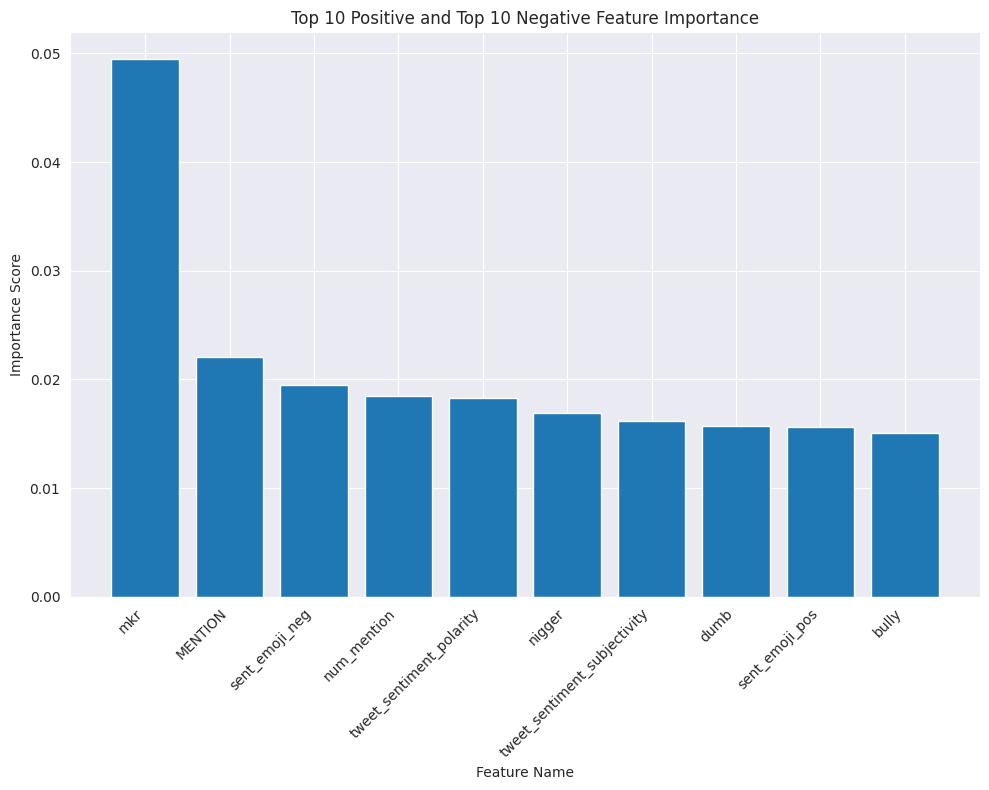

In [ ]:
# Seleccionamos solo las 10 características que aportan más al modelo
top_features = X_columns_sorted[:10]
top_importance = importance_sorted[:10]

# Mostrar el número de la característica, con su nombre, y su score de importancia
for i, (feature, importance) in enumerate(zip(top_features, top_importance)):
    print('Feature: %0d, Name: %s, Score: %.5f' % (i, feature, importance))

# Crear el plot
plt.figure(figsize=(10, 8))  # Ajusta el tamaño del gráfico según necesites
plt.bar(top_features, top_importance)  # Usar nombres de características ordenadas en el eje x

# Mejorar el gráfico
plt.xticks(rotation=45, ha="right")  # Rota los nombres en el eje x para mejor lectura
plt.xlabel('Feature Name')
plt.ylabel('Importance Score')
plt.title('Top 10 Positive and Top 10 Negative Feature Importance')
plt.tight_layout()  # Ajusta automáticamente los parámetros del subplot para que el subplot(s) encaje en el área de la figura.

plt.show()

Como conclusion, vemos que mkr el token que vimos al principio como MKR, es la característica que más aporta al modelo. Seguidos de MENTION, sent_emoji_neg, num_mention y tweet_sentiment_polarity, es decir información que hemos añadido nosotros a los datos.

Por finalizar, podriamos probar a eliminar el token mkr de los datos para ver el resultado, ya que entendemos que MKR puede estar relacionado a un programa de TV en el que se dio un caso puntual de misoginia y hubo un importante aumento de la opinión publica referida a este en twitter, por lo que se puede deducir que son casos aislados y tokens que no vamos a volver a encontrarnos con tweets actuales.